# Creating a Simple Image Processing App with MONAI Deploy App SDK

This tutorial shows how to develop a simple image processing application can be created with MONAI Deploy App SDK.


## Creating Operators and connecting them in Application class

We will implement an application that consists of three Operators:

- **SobelOperator**: Apply a Sobel edge detector.
    - **Input**: a file path ([`DataPath`](/modules/_autosummary/monai.deploy.core.domain.DataPath))
    - **Output**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
- **MedianOperator**: Apply a Median filter for noise reduction.
    - **Input**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
    - **Output**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
- **GaussianOperator**: Apply a Gaussian filter for smoothening.
    - **Input**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
    - **Output**: a file path ([`DataPath`](/modules/_autosummary/monai.deploy.core.domain.DataPath))
    
The workflow of the application would look like this.

```{mermaid}
%%{init: {"theme": "base", "themeVariables": { "fontSize": "16px"}} }%%

classDiagram
    direction LR

    SobelOperator --|> MedianOperator : image...image
    MedianOperator --|> GaussianOperator : image...image

    class SobelOperator {
        <in>image : DISK
        image(out) IN_MEMORY
    }
    class MedianOperator {
        <in>image : IN_MEMORY
        image(out) IN_MEMORY
    }
    class GaussianOperator {
        <in>image : IN_MEMORY
        image(out) DISK
    }
```

### Setup environment


In [1]:
# Install necessary image loading/processing packages for the application
!python -c "import PIL" || pip install -q "Pillow"
!python -c "import skimage" || pip install -q "scikit-image"

# Install MONAI Deploy App SDK package
!python -c "import monai.deploy" || pip install -q "monai-deploy-app-sdk"

### Download test input

We will use a test input from the following.

> Case courtesy of Dr Bruno Di Muzio, <a href="https://radiopaedia.org/?lang=us">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/41113?lang=us">rID: 41113</a>

Test input file path: /tmp/normal-brain-mri-4.png


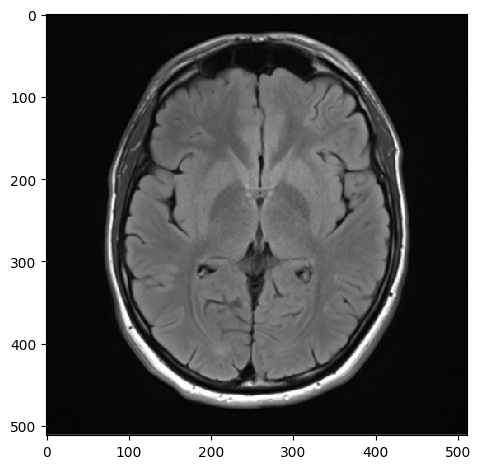

In [2]:
!python -c "import wget" || pip install -q "wget"

from skimage import io
import wget

test_input_path = "/tmp/normal-brain-mri-4.png"
wget.download("https://user-images.githubusercontent.com/1928522/133383228-2357d62d-316c-46ad-af8a-359b56f25c87.png", test_input_path)

print(f"Test input file path: {test_input_path}")

test_image = io.imread(test_input_path)
io.imshow(test_image)

### Setup imports

Let's import necessary classes/decorators to define Application and Operator.

In [3]:
import monai.deploy.core as md  # 'md' stands for MONAI Deploy (or can use 'core' instead)
from monai.deploy.core import (
    Application,
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)

### Creating Operator classes

Each Operator class inherits [Operator](/modules/_autosummary/monai.deploy.core.Operator) class and input/output properties are specified by using [@input](/modules/_autosummary/monai.deploy.core.input)/[@output](/modules/_autosummary/monai.deploy.core.output) decorators.

Note that the first operator(SobelOperator)'s input and the last operator(GaussianOperator)'s output are [DataPath](/modules/_autosummary/monai.deploy.core.domain.DataPath) type with [IOType.DISK](/modules/_autosummary/monai.deploy.core.IOType). Those paths are mapped into input and output paths given by the user during the execution.

Business logic would be implemented in the <a href="../../modules/_autosummary/monai.deploy.core.Operator.html#monai.deploy.core.Operator.compute">compute()</a> method.

#### SobelOperator

SobelOperator is the first operator (A root operator in the workflow graph). <a href="../../modules/_autosummary/monai.deploy.core.InputContext.html#monai.deploy.core.InputContext.get">op_input.get(label)</a> (since only one input is defined in this operator, we don't need to specify an input label) would return an object of [DataPath](/modules/_autosummary/monai.deploy.core.domain.DataPath) and the input file/folder path would be available by accessing the `path` property (`op_input.get().path`).

Once an image data (as a Numpy array) is loaded and processed, [Image](/modules/_autosummary/monai.deploy.core.domain.Image) object is created from the image data and set to the output (<a href="../../modules/_autosummary/monai.deploy.core.OutputContext.html#monai.deploy.core.OutputContext.set">op_output.set(value, label)</a>).

In [4]:
@md.input("image", DataPath, IOType.DISK)
@md.output("image", Image, IOType.IN_MEMORY)
# If `pip_packages` is specified, the definition will be aggregated with the package dependency list of other
# operators and the application in packaging time.
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class SobelOperator(Operator):
    """This Operator implements a Sobel edge detector.

    It has a single input and single output.
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage import filters, io

        input_path = op_input.get().path
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # take the first file

        data_in = io.imread(input_path)[:, :, :3]  # discard alpha channel if exists
        data_out = filters.sobel(data_in)

        op_output.set(Image(data_out))

#### MedianOperator

MedianOperator is a middle operator that accepts data from SobelOperator and pass the processed image data to GaussianOperator.

Its input and output data types are [Image](/modules/_autosummary/monai.deploy.core.domain.Image) and the Numpy array data is available through `asnumpy()` method (`op_input.get().asnumpy()`).

Again, once an image data (as a Numpy array) is loaded and processed, [Image](/modules/_autosummary/monai.deploy.core.domain.Image) object is created and set to the output (<a href="../../modules/_autosummary/monai.deploy.core.OutputContext.html#monai.deploy.core.OutputContext.set">op_output.set(value, label)</a>).

In [5]:
@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", Image, IOType.IN_MEMORY)
# If `pip_packages` is specified, the definition will be aggregated with the package dependency list of other
# operators and the application in packaging time.
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class MedianOperator(Operator):
    """This Operator implements a noise reduction.

    The algorithm is based on the median operator.
    It ingests a single input and provides a single output.
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import median

        data_in = op_input.get().asnumpy()
        data_out = median(data_in)
        op_output.set(Image(data_out))

#### GaussianOperator

GaussianOperator is the last operator (A leaf operator in the workflow graph) and the output path of this operator is mapped to the user-provided output folder so we cannot set a path to `op_output` variable (e.g., `op_output.set(Image(data_out))`).

Instead, we can get the output path through `op_output.get().path` and save the processed image data into a file.

In [6]:
@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", DataPath, IOType.DISK)
# If `pip_packages` is specified, the definition will be aggregated with the package dependency list of other
# operators and the application in packaging time.
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class GaussianOperator(Operator):
    """This Operator implements a smoothening based on Gaussian.

    It ingests a single input and provides a single output.
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import gaussian
        from skimage.io import imsave

        data_in = op_input.get().asnumpy()
        data_out = gaussian(data_in, sigma=0.2)

        output_folder = op_output.get().path
        output_path = output_folder / "final_output.png"
        imsave(output_path, data_out)

### Creating Application class

Our application class would look like below.

It defines `App` class, inheriting [Application](/modules/_autosummary/monai.deploy.core.Application) class.

The requirements (resource and package dependency) for the App can be specified by using [@resource](/modules/_autosummary/monai.deploy.core.resource) and [@env](/modules/_autosummary/monai.deploy.core.env) decorators.

In [7]:
@md.resource(cpu=1)
# pip_packages can be a string that is a path(str) to requirements.txt file or a list of packages.
@md.env(pip_packages=["scikit-image >= 0.17.2"])
class App(Application):
    """This is a very basic application.

    This showcases the MONAI Deploy application framework.
    """

    # App's name. <class name>('App') if not specified.
    name = "simple_imaging_app"
    # App's description. <class docstring> if not specified.
    description = "This is a very simple application."
    # App's version. <git version tag> or '0.0.0' if not specified.
    version = "0.1.0"

    def compose(self):
        """This application has three operators.

        Each operator has a single input and a single output port.
        Each operator performs some kind of image processing function.
        """
        sobel_op = SobelOperator()
        median_op = MedianOperator()
        gaussian_op = GaussianOperator()

        self.add_flow(sobel_op, median_op)
        # self.add_flow(sobel_op, median_op, {"image": "image"})
        # self.add_flow(sobel_op, median_op, {"image": {"image"}})

        self.add_flow(median_op, gaussian_op)

In `compose()` method, objects of `SobelOperator`, `MedianOperator`, and `GaussianOperator` classes are created
and connected through <a href="../../modules/_autosummary/monai.deploy.core.Application.html#monai.deploy.core.Application.add_flow">self.add_flow()</a>.

> add_flow(source_op, destination_op, io_map=None)

`io_map` is a dictionary of mapping from the source operator's label to the destination operator's label(s) and its type is `Dict[str, str|Set[str]]`. 

We can skip specifying `io_map` if both the number of `source_op`'s outputs and the number of `destination_op`'s inputs are one so `self.add_flow(sobel_op, median_op)` is same with `self.add_flow(sobel_op, median_op, {"image": "image"})` or `self.add_flow(sobel_op, median_op, {"image": {"image"}})`.


## Executing app locally

We can execute the app in the Jupyter notebook.

In [8]:
app = App()

In [9]:
app.run(input=test_input_path, output="output")

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 982168, Operator ID: 17f08a58-3988-4c98-9cf9-9d827eb283b7)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 982168, Operator ID: 72c7a0ad-3a47-47fb-896c-18486e79b182)


/home/mqin/src/monai-deploy-app-sdk/.venv/lib/python3.8/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
[2022-10-18 17:29:31,196] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 982168, Operator ID: b07b4eb2-2194-480f-828f-b34080e1a91d)
Done performing execution of operator GaussianOperator



In [10]:
!ls output

1.2.826.0.1.3680043.10.511.3.10195035642003860413057936982968723.dcm
1.2.826.0.1.3680043.10.511.3.10697584562685878853363496613905022.dcm
1.2.826.0.1.3680043.10.511.3.11007185683656203101622184429425124.dcm
1.2.826.0.1.3680043.10.511.3.11010764142907798817891854085040824.dcm
1.2.826.0.1.3680043.10.511.3.11619418586545827859010837278006939.dcm
1.2.826.0.1.3680043.10.511.3.11690041677421435338444238047096628.dcm
1.2.826.0.1.3680043.10.511.3.11766242804993128636390418603798576.dcm
1.2.826.0.1.3680043.10.511.3.12038210552683396113759169001251030.dcm
1.2.826.0.1.3680043.10.511.3.12194673301371710294708887115321840.dcm
1.2.826.0.1.3680043.10.511.3.12839953903115687811576743419329745.dcm
1.2.826.0.1.3680043.10.511.3.19954741813431048648918533230571869.dcm
1.2.826.0.1.3680043.10.511.3.28115597778269862176555674040553881.dcm
1.2.826.0.1.3680043.10.511.3.44487290837312664283259666820005457.dcm
1.2.826.0.1.3680043.10.511.3.45596709770136744924389849060252151.dcm
1.2.826.0.1.3680043.10.511.3.48053

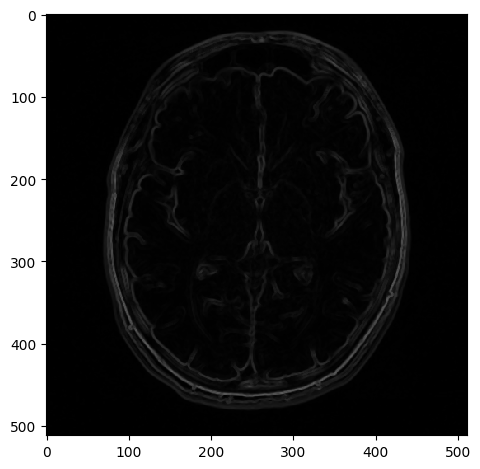

In [11]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)

Once the application is verified inside Jupyter notebook, we can write the above Python code into Python files in an application folder.

The application folder structure would look like below:

```bash
simple_imaging_app
├── __main__.py
├── app.py
├── gaussian_operator.py
├── median_operator.py
└── sobel_operator.py
```

:::{note}
We can create a single application Python file (such as `simple_imaging_app.py`) that includes the content of the files, instead of creating multiple files.
You will see such example in <a href="./02_mednist_app.html#executing-app-locally">MedNist Classifier Tutorial</a>.
:::

In [12]:
# Create an application folder
!mkdir -p simple_imaging_app

### sobel_operator.py

In [13]:
%%writefile simple_imaging_app/sobel_operator.py
import monai.deploy.core as md
from monai.deploy.core import (
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)


@md.input("image", DataPath, IOType.DISK)
@md.output("image", Image, IOType.IN_MEMORY)
class SobelOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage import filters, io

        input_path = op_input.get().path
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # take the first file

        data_in = io.imread(input_path)[:, :, :3]  # discard alpha channel if exists
        data_out = filters.sobel(data_in)

        op_output.set(Image(data_out))

Overwriting simple_imaging_app/sobel_operator.py


### median_operator.py

In [14]:
%%writefile simple_imaging_app/median_operator.py
import monai.deploy.core as md
from monai.deploy.core import ExecutionContext, Image, InputContext, IOType, Operator, OutputContext, output


@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", Image, IOType.IN_MEMORY)
class MedianOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import median

        data_in = op_input.get().asnumpy()
        data_out = median(data_in)
        op_output.set(Image(data_out))

Overwriting simple_imaging_app/median_operator.py


### gaussian_operator.py

In [15]:
%%writefile simple_imaging_app/gaussian_operator.py
import monai.deploy.core as md
from monai.deploy.core import (
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)


@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", DataPath, IOType.DISK)
class GaussianOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import gaussian
        from skimage.io import imsave

        data_in = op_input.get().asnumpy()
        data_out = gaussian(data_in, sigma=0.2)

        output_folder = op_output.get().path
        output_path = output_folder / "final_output.png"
        imsave(output_path, data_out)

Overwriting simple_imaging_app/gaussian_operator.py


### app.py

In [16]:
%%writefile simple_imaging_app/app.py
import monai.deploy.core as md
from gaussian_operator import GaussianOperator
from median_operator import MedianOperator
from sobel_operator import SobelOperator

from monai.deploy.core import Application


@md.resource(cpu=1)
@md.env(pip_packages=["scikit-image >= 0.17.2"])
class App(Application):
    def compose(self):
        sobel_op = SobelOperator()
        median_op = MedianOperator()
        gaussian_op = GaussianOperator()

        self.add_flow(sobel_op, median_op)
        self.add_flow(median_op, gaussian_op)

# Run the application when this file is executed.
if __name__ == "__main__":
    App(do_run=True)

Overwriting simple_imaging_app/app.py


```python
if __name__ == "__main__":
    App(do_run=True)
```

The above lines are needed to execute the application code by using `python` interpreter.

### \_\_main\_\_.py

\_\_main\_\_.py is needed for <a href="../../developing_with_sdk/packaging_app.html">MONAI Application Packager</a> to detect the main application code (`app.py`) when the application is executed with the application folder path (e.g., `python simple_imaging_app`).

In [17]:
%%writefile simple_imaging_app/__main__.py
from app import App

if __name__ == "__main__":
    App(do_run=True)

Overwriting simple_imaging_app/__main__.py


In [18]:
!ls simple_imaging_app

app.py		      __main__.py	  __pycache__
gaussian_operator.py  median_operator.py  sobel_operator.py


In this time, let's execute the app in the command line.

In [19]:
!python simple_imaging_app -i {test_input_path} -o output

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 982716, Operator ID: a69f7049-06ff-4d92-bab5-50a3bf545616)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 982716, Operator ID: a2a5878a-2279-4a9d-9f25-22d62ea368c9)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 982716, Operator ID: 0f9c879e-8124-44fe-8a8f-943c96efc8d2)
/home/mqin/src/monai-deploy-app-sdk/.venv/lib/python3.8/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
[2022-10-18 17:29:37,907] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Conve

Above command is same with the following command line:

In [20]:
!monai-deploy exec simple_imaging_app -i {test_input_path} -o output

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 982757, Operator ID: bc876ff4-9349-4805-9500-a4a0f79326c6)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 982757, Operator ID: a0109f55-1d2b-45ae-bf41-e97c1b100574)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 982757, Operator ID: 42ab046c-f81b-446e-a130-f126650f3770)
/home/mqin/src/monai-deploy-app-sdk/.venv/lib/python3.8/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
[2022-10-18 17:29:42,717] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Conve

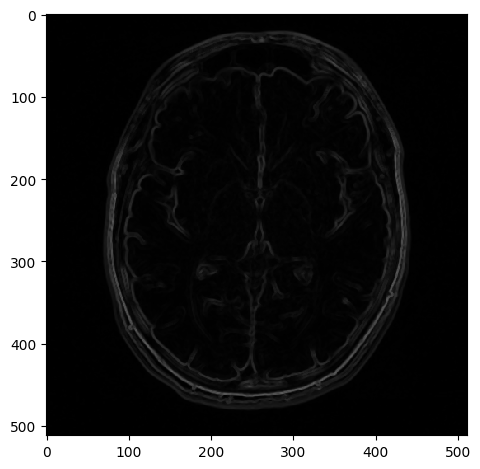

In [21]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)

## Packaging app

Let's package the app with <a href="../../developing_with_sdk/packaging_app.html">MONAI Application Packager</a>.

In [22]:
!monai-deploy package simple_imaging_app --tag simple_app:latest  # -l DEBUG

Building MONAI Application Package... Done
[2022-10-18 17:32:36,953] [INFO] (app_packager) - Successfully built simple_app:latest


:::{note}
Building a MONAI Application Package (Docker image) can take time. Use `-l DEBUG` option if you want to see the progress.

:::

We can see that the Docker image is created.

In [23]:
!docker image ls | grep simple_app

simple_app                                                            latest                                     2b8fbb1eec36   4 seconds ago       15.6GB


## Executing packaged app locally

The packaged app can be run locally through <a href="../../developing_with_sdk/executing_packaged_app_locally.html">MONAI Application Runner</a>.

In [24]:
# Copy a test input file to 'input' folder
!mkdir -p input && rm -rf input/*
!cp {test_input_path} input/

# Launch the app
!monai-deploy run simple_app:latest input output

Checking dependencies...
--> Verifying if "docker" is installed...

--> Verifying if "simple_app:latest" is available...

Checking for MAP "simple_app:latest" locally
"simple_app:latest" found.

Reading MONAI App Package manifest...
Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 1, Operator ID: 4be86b2a-0f0e-44b4-bcb5-6d49b04a7bd2)
[2022-10-19 00:32:50,281] [INFO] (matplotlib.font_manager) - generated new fontManager
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 1, Operator ID: a92fe3dd-1848-4f56-a0f1-c744863aba9f)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 1, Operator ID: 61ba09a4-2af4-45af-95de-50545f8d7b90)
/root/.local/lib/python3.8/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dime

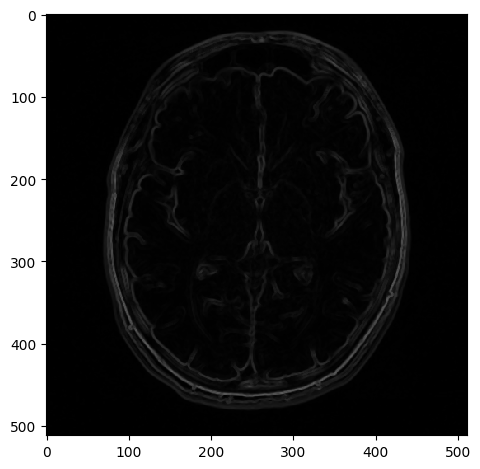

In [25]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)